In [20]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population
import config as cfg
cfg.set_population_config("sea_jpt_cn")

PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load Results from Both Approaches

In [21]:
# Load FST-only results (from 04a)
fst_results_path = project_root / "output" / "ml_models" / "sea_jpt_cn" / "feature_size_results.csv"
fst_results = pd.read_csv(fst_results_path)
fst_results['Method'] = 'FST-only'

print(f"FST-only results: {fst_results.shape}")
print(f"Models: {fst_results['Model'].unique()}")
print(f"Feature sizes: {sorted(fst_results['N_Features'].unique())}")

FST-only results: (50, 5)
Models: ['Random Forest' 'XGBoost' 'Logistic Regression' 'SVM (RBF)'
 'Gradient Boosting']
Feature sizes: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50)]


In [22]:
# Load Consensus SNP results (FST + Statistical, from 04c)
stat_results_path = PATHS.OUTPUT_DIR / "consensus_snps_reduced_results.csv"
stat_results = pd.read_csv(stat_results_path)
stat_results['Method'] = 'FST+Statistical'

print(f"\nFST+Statistical results: {stat_results.shape}")
print(f"Models: {stat_results['Model'].unique()}")
print(f"Feature sizes: {sorted(stat_results['N_Features'].unique())}")


FST+Statistical results: (50, 5)
Models: ['Random Forest' 'XGBoost' 'Logistic Regression' 'SVM (RBF)'
 'SVM (Linear)' 'K-Nearest Neighbors' 'Naive Bayes' 'Gradient Boosting'
 'AdaBoost' 'MLP Neural Network']
Feature sizes: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25)]


In [23]:
# Load full-feature CV results for both methods
stat_cv_path = PATHS.OUTPUT_DIR / "consensus_snps_cv_results.csv"
stat_cv_results = pd.read_csv(stat_cv_path)
stat_cv_results['Method'] = 'FST+Statistical'

print(f"\nFST+Statistical full CV results:")
display(stat_cv_results[['Model', 'Accuracy_Mean', 'Accuracy_Std', 'F1_Mean']].head(10))


FST+Statistical full CV results:


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean
0,Logistic Regression,0.847149,0.043066,0.847714
1,XGBoost,0.845168,0.021926,0.845782
2,SVM (RBF),0.829267,0.039839,0.830583
3,Random Forest,0.827327,0.014191,0.828119
4,SVM (Linear),0.821366,0.048766,0.822279
5,MLP Neural Network,0.809465,0.031951,0.808767
6,Gradient Boosting,0.803505,0.022714,0.804376
7,AdaBoost,0.785683,0.035941,0.785342
8,Naive Bayes,0.708158,0.049277,0.705819
9,K-Nearest Neighbors,0.700337,0.047014,0.703936


In [24]:
# Combine results for comparison
# Find common feature sizes
fst_sizes = set(fst_results['N_Features'].unique())
stat_sizes = set(stat_results['N_Features'].unique())
common_sizes = sorted(fst_sizes.intersection(stat_sizes))

print(f"Common feature sizes: {common_sizes}")

# Filter to common sizes and models
fst_common = fst_results[fst_results['N_Features'].isin(common_sizes)].copy()
stat_common = stat_results[stat_results['N_Features'].isin(common_sizes)].copy()

# Combine
combined_results = pd.concat([fst_common, stat_common], ignore_index=True)
print(f"\nCombined results: {combined_results.shape}")

Common feature sizes: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25)]

Combined results: (75, 5)


## Step 2: Summary Statistics Comparison

In [25]:
# Summary by method
print("="*70)
print("PERFORMANCE SUMMARY BY METHOD")
print("="*70)

for method in ['FST-only', 'FST+Statistical']:
    method_data = combined_results[combined_results['Method'] == method]
    print(f"\n{method}:")
    print(f"  Average Accuracy: {method_data['Accuracy_Mean'].mean():.4f}")
    print(f"  Best Accuracy: {method_data['Accuracy_Mean'].max():.4f}")
    best_row = method_data.loc[method_data['Accuracy_Mean'].idxmax()]
    print(f"  Best Config: {best_row['Model']} with {int(best_row['N_Features'])} SNPs")

PERFORMANCE SUMMARY BY METHOD

FST-only:
  Average Accuracy: 0.7903
  Best Accuracy: 0.8809
  Best Config: SVM (RBF) with 25 SNPs

FST+Statistical:
  Average Accuracy: 0.7640
  Best Accuracy: 0.8472
  Best Config: XGBoost with 20 SNPs


In [26]:
# Create pivot table for each method
fst_pivot = fst_common.pivot(index='Model', columns='N_Features', values='Accuracy_Mean')
stat_pivot = stat_common.pivot(index='Model', columns='N_Features', values='Accuracy_Mean')

print("\nFST-only Accuracy by Model and Feature Size:")
display(fst_pivot.round(4))

print("\nFST+Statistical Accuracy by Model and Feature Size:")
display(stat_pivot.round(4))


FST-only Accuracy by Model and Feature Size:


N_Features,5,10,15,20,25
Model,,,,,
Gradient Boosting,0.6765,0.7659,0.7976,0.8055,0.8511
Logistic Regression,0.6884,0.7619,0.8016,0.8254,0.8730
Random Forest,0.6825,0.7759,0.8135,0.8313,0.8690
SVM (RBF),0.6786,0.7858,0.8055,0.8333,0.8809
XGBoost,0.6845,0.7619,0.8095,0.8234,0.8750



FST+Statistical Accuracy by Model and Feature Size:


N_Features,5,10,15,20,25
Model,,,,,
AdaBoost,0.7361,0.7737,0.7718,0.7976,0.7857
Gradient Boosting,0.7420,0.7658,0.7916,0.8015,0.8015
K-Nearest Neighbors,0.6171,0.6210,0.6667,0.7241,0.7043
Logistic Regression,0.7301,0.7777,0.8194,0.8392,0.8392
MLP Neural Network,0.7242,0.7480,0.8054,0.8094,0.8372
Naive Bayes,0.5674,0.6368,0.6487,0.6667,0.7063
Random Forest,0.7341,0.7717,0.8054,0.8353,0.8293
SVM (Linear),0.7341,0.7698,0.8095,0.8234,0.8253
SVM (RBF),0.7321,0.7916,0.8194,0.8273,0.8273


In [27]:
# Compute difference (FST+Statistical - FST-only)
# Align models and feature sizes
common_models = list(set(fst_pivot.index).intersection(set(stat_pivot.index)))

diff_pivot = stat_pivot.loc[common_models, common_sizes] - fst_pivot.loc[common_models, common_sizes]

print("\nDifference (FST+Statistical - FST-only):")
print("Positive = FST+Statistical is better, Negative = FST-only is better")
display(diff_pivot.round(4))


Difference (FST+Statistical - FST-only):
Positive = FST+Statistical is better, Negative = FST-only is better


N_Features,5,10,15,20,25
Model,,,,,
Logistic Regression,0.0417,0.0159,0.0178,0.0138,-0.0338
Gradient Boosting,0.0655,-0.0001,-0.0060,-0.0040,-0.0496
XGBoost,0.0457,0.0118,0.0019,0.0238,-0.0298
Random Forest,0.0516,-0.0041,-0.0081,0.0040,-0.0397
SVM (RBF),0.0536,0.0058,0.0138,-0.0060,-0.0536


## Step 3: Visual Comparison

In [28]:
# More distinct colors for populations
colors = {'CN': '#e41a1c', 'JPT': '#377eb8', 'SEA': '#4daf4a'}
method_colors = {'FST-only': '#1f77b4', 'FST+Statistical': '#ff7f0e'}

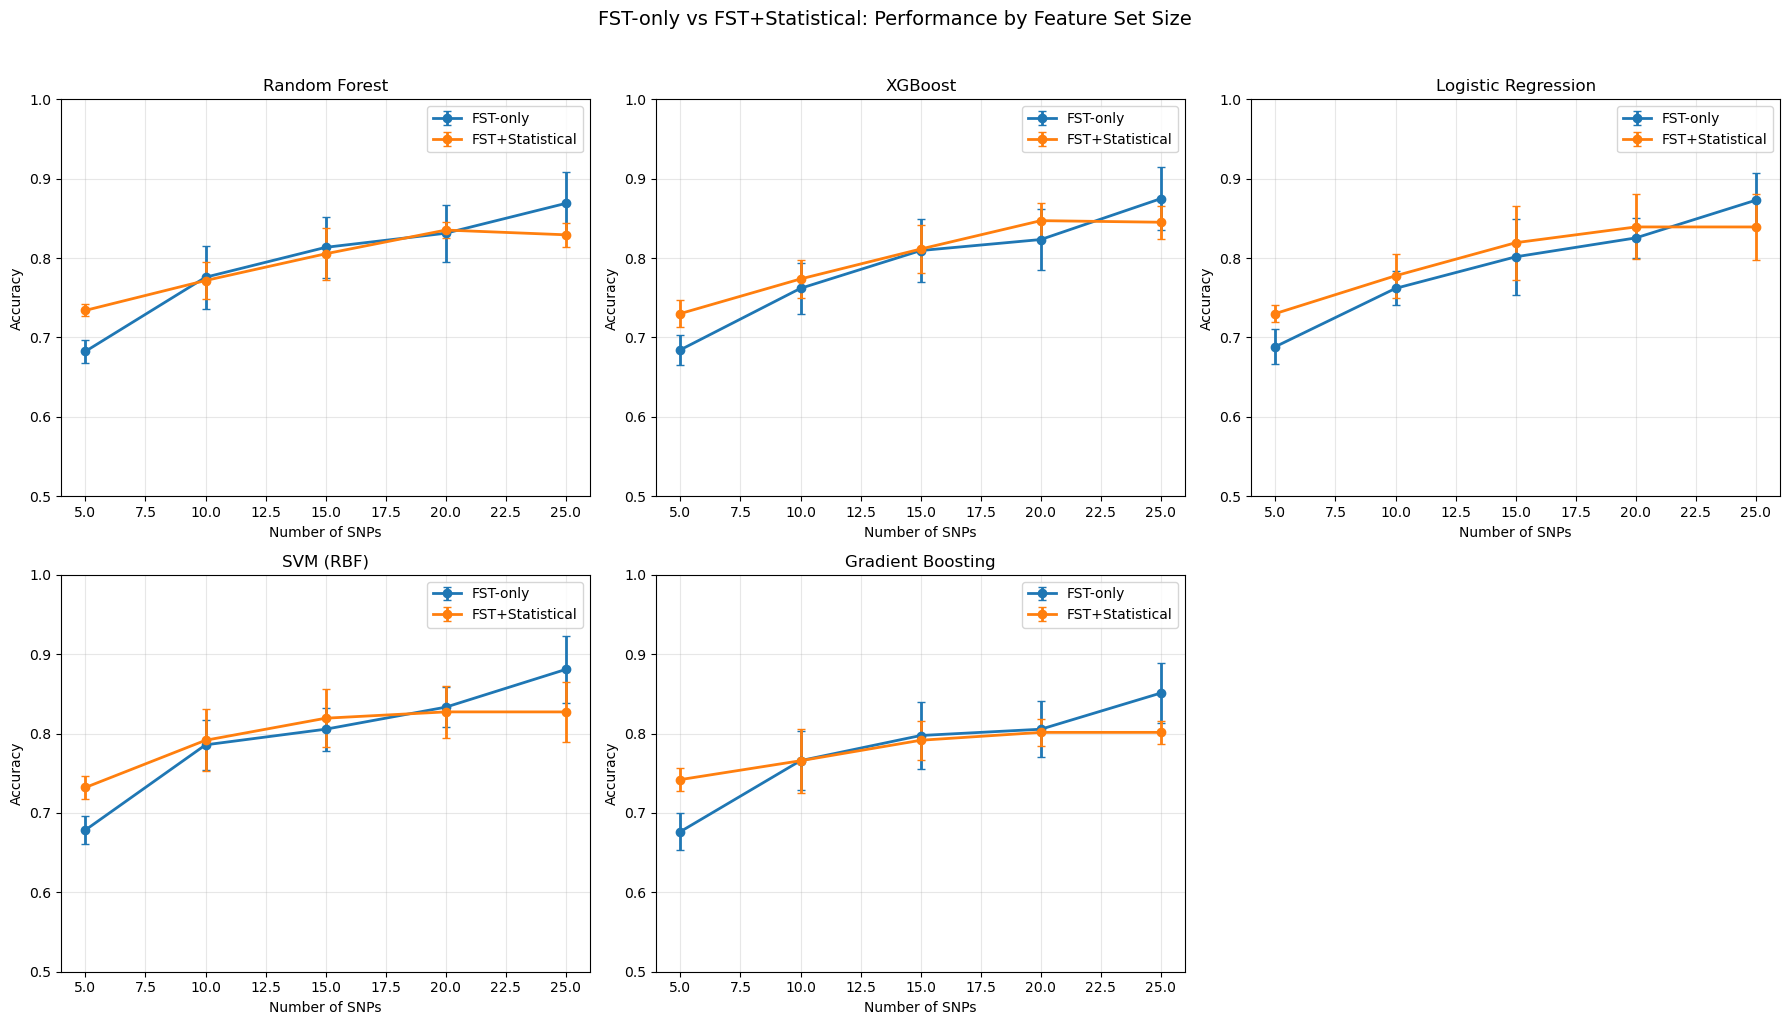

In [29]:
# Plot 1: Side-by-side comparison by feature size
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top models to compare
top_models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM (RBF)', 'Gradient Boosting']

for idx, model in enumerate(top_models):
    ax = axes.flat[idx]
    
    for method, color in method_colors.items():
        method_data = combined_results[
            (combined_results['Method'] == method) & 
            (combined_results['Model'] == model)
        ].sort_values('N_Features')
        
        if len(method_data) > 0:
            ax.errorbar(method_data['N_Features'], method_data['Accuracy_Mean'],
                       yerr=method_data['Accuracy_Std'], marker='o', label=method,
                       color=color, capsize=3, linewidth=2, markersize=6)
    
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Accuracy')
    ax.set_title(model)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.5, 1.0)

# Hide empty subplot
axes.flat[-1].axis('off')

plt.suptitle('FST-only vs FST+Statistical: Performance by Feature Set Size', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

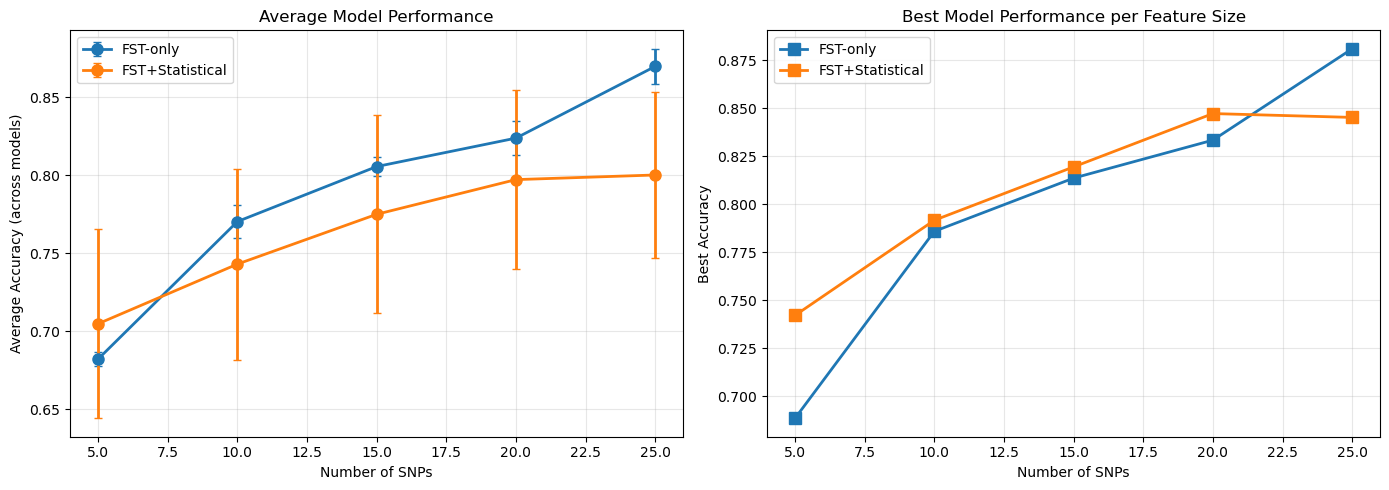

In [30]:
# Plot 2: Average performance across all models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Average accuracy by feature size
ax = axes[0]
for method, color in method_colors.items():
    method_data = combined_results[combined_results['Method'] == method]
    avg_by_size = method_data.groupby('N_Features')['Accuracy_Mean'].agg(['mean', 'std']).reset_index()
    ax.errorbar(avg_by_size['N_Features'], avg_by_size['mean'],
               yerr=avg_by_size['std'], marker='o', label=method,
               color=color, capsize=3, linewidth=2, markersize=8)

ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Average Accuracy (across models)')
ax.set_title('Average Model Performance')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Best model accuracy by feature size
ax = axes[1]
for method, color in method_colors.items():
    method_data = combined_results[combined_results['Method'] == method]
    best_by_size = method_data.groupby('N_Features')['Accuracy_Mean'].max().reset_index()
    ax.plot(best_by_size['N_Features'], best_by_size['Accuracy_Mean'],
           marker='s', label=method, color=color, linewidth=2, markersize=8)

ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Best Accuracy')
ax.set_title('Best Model Performance per Feature Size')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

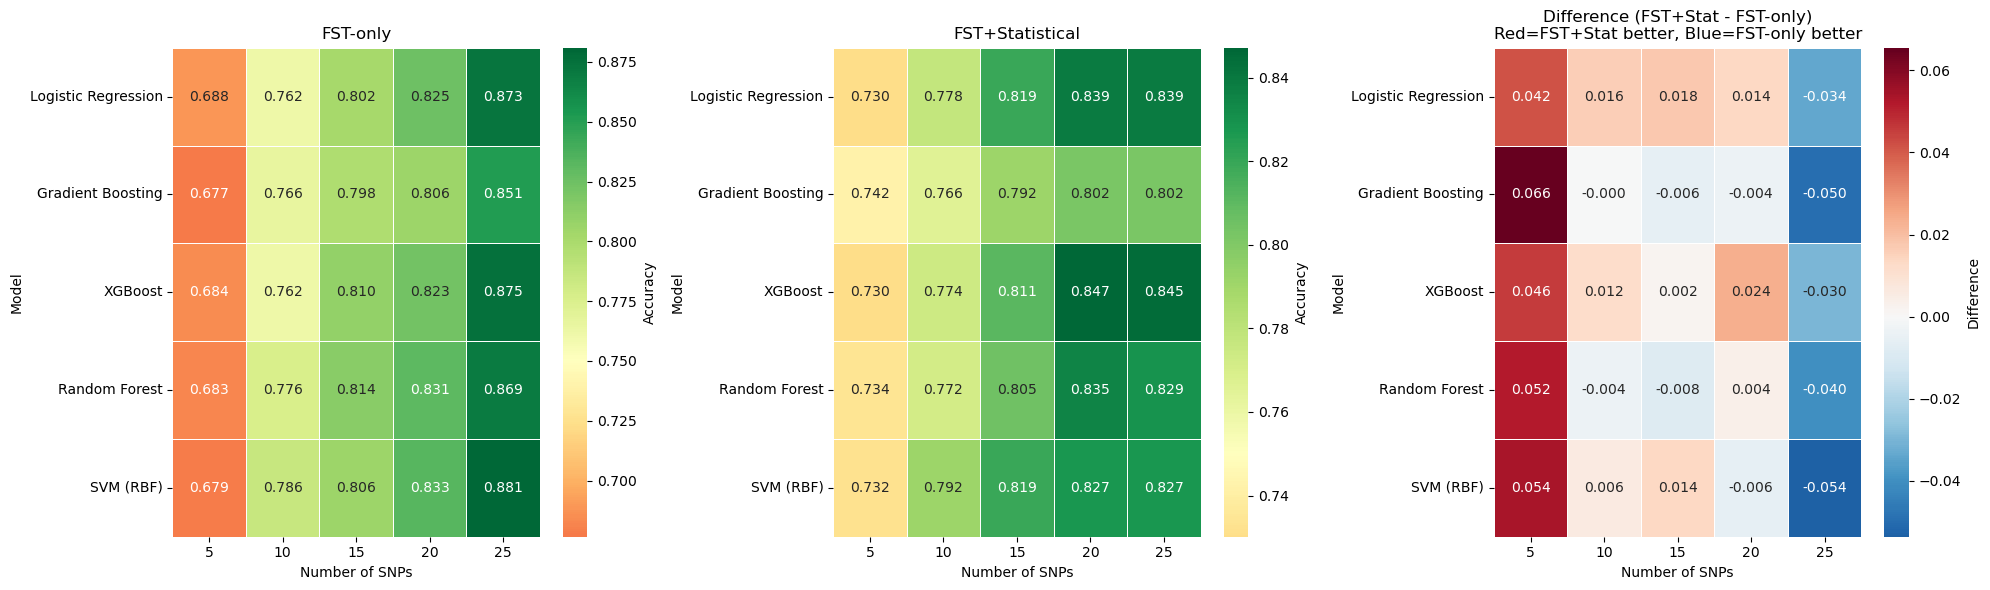

In [31]:
# Plot 3: Heatmap of differences
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# FST-only heatmap
ax = axes[0]
sns.heatmap(fst_pivot.loc[common_models], annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.75, linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('FST-only')
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Model')

# FST+Statistical heatmap
ax = axes[1]
sns.heatmap(stat_pivot.loc[common_models], annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.75, linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('FST+Statistical')
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Model')

# Difference heatmap
ax = axes[2]
sns.heatmap(diff_pivot, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, linewidths=0.5, ax=ax, cbar_kws={'label': 'Difference'})
ax.set_title('Difference (FST+Stat - FST-only)\nRed=FST+Stat better, Blue=FST-only better')
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Model')

plt.tight_layout()
plt.show()

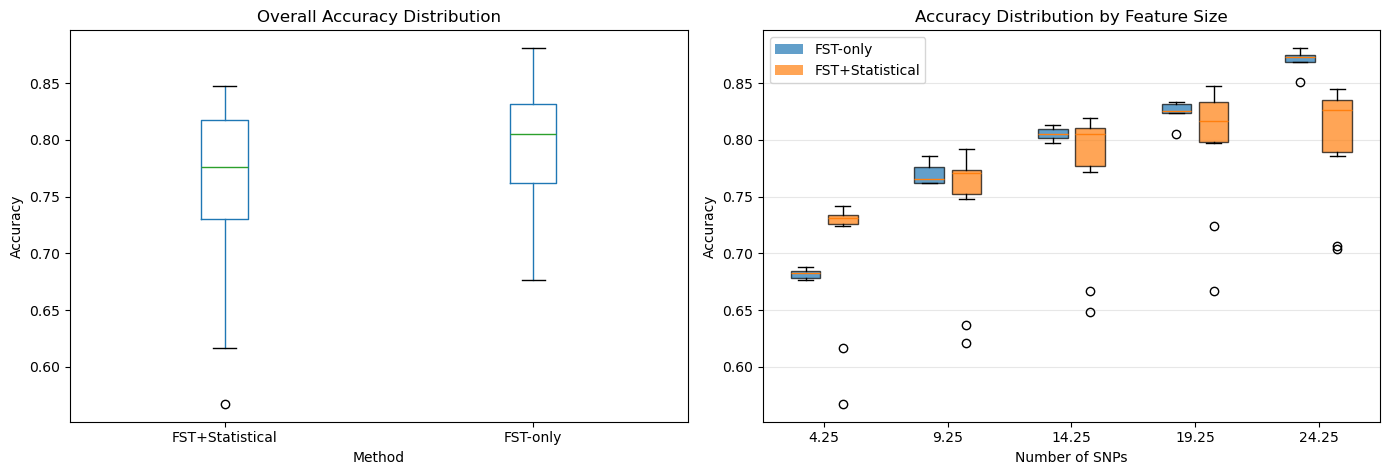

In [32]:
# Plot 4: Box plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By method (overall)
ax = axes[0]
combined_results.boxplot(column='Accuracy_Mean', by='Method', ax=ax, grid=False)
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
ax.set_title('Overall Accuracy Distribution')
plt.suptitle('')  # Remove auto-generated title

# By method and feature size
ax = axes[1]
for i, method in enumerate(['FST-only', 'FST+Statistical']):
    method_data = combined_results[combined_results['Method'] == method]
    positions = np.array(common_sizes) + (i - 0.5) * 1.5
    bp = ax.boxplot([method_data[method_data['N_Features'] == n]['Accuracy_Mean'].values 
                    for n in common_sizes],
                   positions=positions, widths=1.2,
                   patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor(list(method_colors.values())[i])
        patch.set_alpha(0.7)

ax.set_xticks(common_sizes)
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Distribution by Feature Size')
ax.legend([plt.Rectangle((0,0),1,1, fc=c, alpha=0.7) for c in method_colors.values()],
          method_colors.keys())
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 4: Statistical Significance Testing

In [33]:
from scipy import stats

# Paired t-test for each feature size
print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)
print("\nPaired t-test comparing FST-only vs FST+Statistical at each feature size:")
print("-"*70)

significance_results = []

for n_features in common_sizes:
    fst_acc = fst_common[fst_common['N_Features'] == n_features]['Accuracy_Mean'].values
    stat_acc = stat_common[stat_common['N_Features'] == n_features]['Accuracy_Mean'].values
    
    # Align by model name
    fst_models = fst_common[fst_common['N_Features'] == n_features].set_index('Model')['Accuracy_Mean']
    stat_models = stat_common[stat_common['N_Features'] == n_features].set_index('Model')['Accuracy_Mean']
    
    common_idx = fst_models.index.intersection(stat_models.index)
    fst_aligned = fst_models.loc[common_idx]
    stat_aligned = stat_models.loc[common_idx]
    
    t_stat, p_value = stats.ttest_rel(stat_aligned, fst_aligned)
    mean_diff = stat_aligned.mean() - fst_aligned.mean()
    
    significance_results.append({
        'N_Features': n_features,
        'FST_Mean': fst_aligned.mean(),
        'Stat_Mean': stat_aligned.mean(),
        'Difference': mean_diff,
        't_statistic': t_stat,
        'p_value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })
    
    sig = "*" if p_value < 0.05 else ""
    print(f"{n_features} SNPs: FST={fst_aligned.mean():.4f}, Stat={stat_aligned.mean():.4f}, "
          f"Diff={mean_diff:+.4f}, p={p_value:.4f} {sig}")

sig_df = pd.DataFrame(significance_results)
print("\n* indicates p < 0.05")

STATISTICAL SIGNIFICANCE TESTING

Paired t-test comparing FST-only vs FST+Statistical at each feature size:
----------------------------------------------------------------------
5 SNPs: FST=0.6821, Stat=0.7337, Diff=+0.0516, p=0.0002 *
10 SNPs: FST=0.7703, Stat=0.7761, Diff=+0.0058, p=0.1878 
15 SNPs: FST=0.8056, Stat=0.8094, Diff=+0.0039, p=0.4943 
20 SNPs: FST=0.8238, Stat=0.8301, Diff=+0.0063, p=0.3211 
25 SNPs: FST=0.8698, Stat=0.8285, Diff=-0.0413, p=0.0008 *

* indicates p < 0.05


In [34]:
# Overall comparison (Wilcoxon signed-rank test)
print("\nOverall Comparison (Wilcoxon signed-rank test):")
print("-"*70)

# Merge on Model and N_Features
merged = fst_common.merge(stat_common, on=['Model', 'N_Features'], suffixes=('_FST', '_Stat'))

stat_test, p_val = stats.wilcoxon(merged['Accuracy_Mean_Stat'], merged['Accuracy_Mean_FST'])
print(f"Wilcoxon statistic: {stat_test:.4f}")
print(f"p-value: {p_val:.4f}")
print(f"Significant difference: {'Yes' if p_val < 0.05 else 'No'}")

# Effect size (rank-biserial correlation)
n = len(merged)
r = 1 - (2 * stat_test) / (n * (n + 1) / 2)
print(f"Effect size (r): {r:.4f}")


Overall Comparison (Wilcoxon signed-rank test):
----------------------------------------------------------------------
Wilcoxon statistic: 130.0000
p-value: 0.3957
Significant difference: No
Effect size (r): 0.2000


## Step 5: Best Configuration Analysis

In [35]:
# Find best configuration for each method
print("="*70)
print("BEST CONFIGURATIONS")
print("="*70)

for method in ['FST-only', 'FST+Statistical']:
    method_data = combined_results[combined_results['Method'] == method]
    best_idx = method_data['Accuracy_Mean'].idxmax()
    best = method_data.loc[best_idx]
    
    print(f"\n{method}:")
    print(f"  Best Model: {best['Model']}")
    print(f"  N Features: {int(best['N_Features'])}")
    print(f"  Accuracy: {best['Accuracy_Mean']:.4f} ± {best['Accuracy_Std']:.4f}")
    
    # Top 3
    print(f"\n  Top 3 configurations:")
    top3 = method_data.nlargest(3, 'Accuracy_Mean')
    for _, row in top3.iterrows():
        print(f"    {row['Model']} ({int(row['N_Features'])} SNPs): {row['Accuracy_Mean']:.4f}")

BEST CONFIGURATIONS

FST-only:
  Best Model: SVM (RBF)
  N Features: 25
  Accuracy: 0.8809 ± 0.0421

  Top 3 configurations:
    SVM (RBF) (25 SNPs): 0.8809
    XGBoost (25 SNPs): 0.8750
    Logistic Regression (25 SNPs): 0.8730

FST+Statistical:
  Best Model: XGBoost
  N Features: 20
  Accuracy: 0.8472 ± 0.0226

  Top 3 configurations:
    XGBoost (20 SNPs): 0.8472
    XGBoost (25 SNPs): 0.8452
    Logistic Regression (20 SNPs): 0.8392


In [36]:
# Performance at specific feature counts
print("\n" + "="*70)
print("PERFORMANCE AT KEY FEATURE COUNTS")
print("="*70)

for n_feat in [10, 25, 50]:
    if n_feat in common_sizes:
        print(f"\n{n_feat} SNPs:")
        for method in ['FST-only', 'FST+Statistical']:
            method_data = combined_results[
                (combined_results['Method'] == method) & 
                (combined_results['N_Features'] == n_feat)
            ]
            best_idx = method_data['Accuracy_Mean'].idxmax()
            best = method_data.loc[best_idx]
            print(f"  {method}: {best['Model']} ({best['Accuracy_Mean']:.4f})")


PERFORMANCE AT KEY FEATURE COUNTS

10 SNPs:
  FST-only: SVM (RBF) (0.7858)
  FST+Statistical: SVM (RBF) (0.7916)

25 SNPs:
  FST-only: SVM (RBF) (0.8809)
  FST+Statistical: XGBoost (0.8452)


## Step 6: Save Comparison Results

In [37]:
# Save comparison results
output_dir = PATHS.OUTPUT_DIR

# Save combined results
combined_path = str(output_dir / "method_comparison_results.csv")
combined_results.to_csv(combined_path, index=False)
print(f"Combined results saved: {combined_path}")

# Save significance results
sig_path = str(output_dir / "method_comparison_significance.csv")
sig_df.to_csv(sig_path, index=False)
print(f"Significance results saved: {sig_path}")

# Save difference heatmap data
diff_path = str(output_dir / "method_comparison_difference.csv")
diff_pivot.to_csv(diff_path)
print(f"Difference matrix saved: {diff_path}")

Combined results saved: 1000genomes/output_sea_jpt_cn/method_comparison_results.csv
Significance results saved: 1000genomes/output_sea_jpt_cn/method_comparison_significance.csv
Difference matrix saved: 1000genomes/output_sea_jpt_cn/method_comparison_difference.csv


## Summary

In [38]:
print("="*70)
print("METHOD COMPARISON SUMMARY")
print("="*70)

# Overall statistics
fst_mean = fst_common['Accuracy_Mean'].mean()
stat_mean = stat_common['Accuracy_Mean'].mean()
fst_best = fst_common['Accuracy_Mean'].max()
stat_best = stat_common['Accuracy_Mean'].max()

print(f"\nOverall Performance:")
print(f"  FST-only:        Mean={fst_mean:.4f}, Best={fst_best:.4f}")
print(f"  FST+Statistical: Mean={stat_mean:.4f}, Best={stat_best:.4f}")
print(f"  Difference:      Mean={stat_mean-fst_mean:+.4f}, Best={stat_best-fst_best:+.4f}")

# Winner count
fst_wins = (diff_pivot < 0).sum().sum()
stat_wins = (diff_pivot > 0).sum().sum()
ties = (diff_pivot == 0).sum().sum()

print(f"\nWin/Loss (across all model-feature combinations):")
print(f"  FST-only wins: {fst_wins}")
print(f"  FST+Statistical wins: {stat_wins}")
print(f"  Ties: {ties}")

# Conclusion
print(f"\nConclusion:")
if stat_mean > fst_mean:
    print(f"  FST+Statistical filtering shows overall better performance.")
    print(f"  The statistical tests help identify more discriminative SNPs.")
else:
    print(f"  FST-only selection shows overall better performance.")
    print(f"  Additional statistical filtering may be overly restrictive.")

print(f"\nOutput Files:")
print(f"  - method_comparison_results.csv")
print(f"  - method_comparison_significance.csv")
print(f"  - method_comparison_difference.csv")

METHOD COMPARISON SUMMARY

Overall Performance:
  FST-only:        Mean=0.7903, Best=0.8809
  FST+Statistical: Mean=0.7640, Best=0.8472
  Difference:      Mean=-0.0263, Best=-0.0337

Win/Loss (across all model-feature combinations):
  FST-only wins: 11
  FST+Statistical wins: 14
  Ties: 0

Conclusion:
  FST-only selection shows overall better performance.
  Additional statistical filtering may be overly restrictive.

Output Files:
  - method_comparison_results.csv
  - method_comparison_significance.csv
  - method_comparison_difference.csv
